# Colates, cleans and analyses canopy temperature data from Rain shelter wheat trail

In [75]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import matplotlib.dates as mdates
import GraphHelpers as GH

In [76]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')
Data.columns = Data.columns.droplevel(level=[3,4,5,6])
Data.sort_index(axis=1, inplace = True)
Data.sort_index(inplace = True)

#Add surface temperature difference (TsTa) into DataFrame
Data = Data.join(pd.concat([np.subtract(Data.loc[:,'IR_SurfaceTemp'], Data.loc[:,'AirTemperature'].values)], #Subtract Ts from Ta to get the differeince
          axis=1,keys=['TsTa'],names=['Measurement']),sort=True) # Join a descriptor level into the index

Ic = 0.8
Icl = 0.9
Cp = 1013 #Heat capacity of air Joule/kg/oC
Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

In [77]:
GPs = GH.SetGraphicsPatterns(Data.IR_SurfaceTemp.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = Data.index.min()
End = Data.index.max()

Irrigation
['2D', '7D', '14D', '21D', 'MD', 'LD']
Species
['Peas']
Treatments
MultiIndex([( '2D', 'Peas'),
            ( '7D', 'Peas'),
            ('14D', 'Peas'),
            ('21D', 'Peas'),
            ( 'MD', 'Peas'),
            ( 'LD', 'Peas')],
           )
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
         Lin     Col   Alp Mar     MFC
2D  Peas   -  orange  0.15   o  orange
7D  Peas   -   green  0.15   o   white
14D Peas   -  purple  0.15   o   white
21D Peas  --  orange  0.45   ^   white
MD  Peas  --   green  0.45   ^   white
LD  Peas  --  purple  0.45   ^   white


## Look at treatment patterns of surface temp differential

In [78]:
Start = '2021-11-15'
End = '2022-01-29'

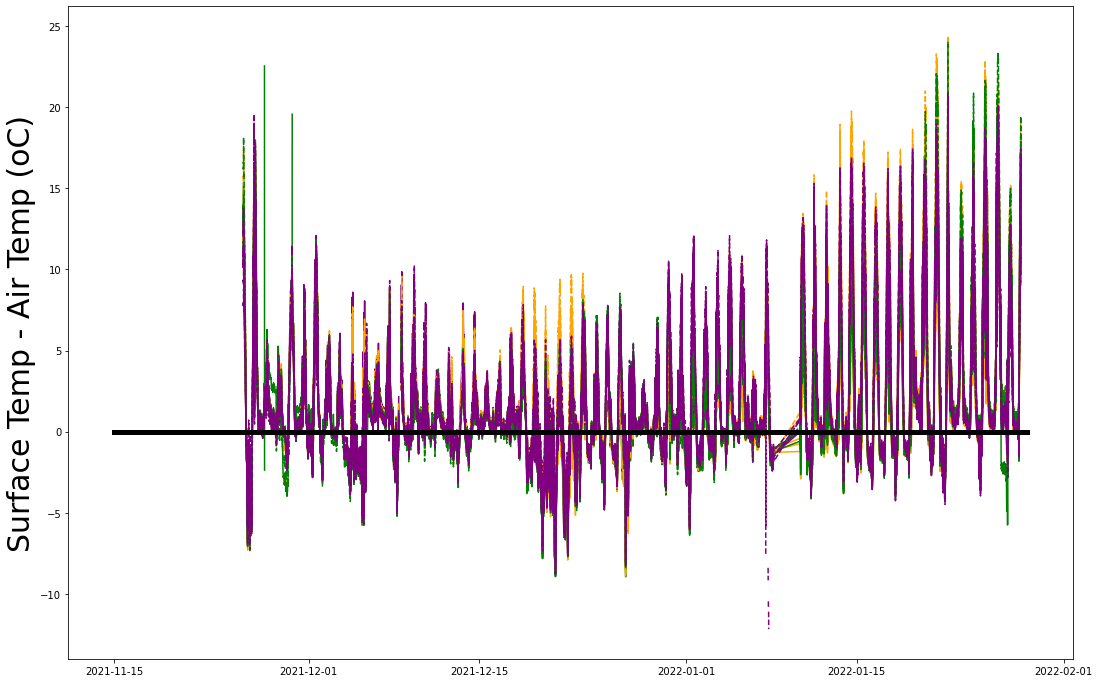

In [79]:
Figure = plt.figure(figsize=(18, 12))
ax = Figure.add_subplot(1,1,1)
GH.AddIndexedPlot(Data.TsTa.loc[Start:End],ax,GPs,1.5)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.plot(pd.to_datetime([Start,End]),[0,0], c='k', linewidth=5)

### The temperature differences are comming mostly during the day time but they are non zero at night and some treatment differences remain so will will remove the night time data from our daily means

## Set up a mask for day-light hours and filter out all data after dark

### First look at the radiation data

<AxesSubplot:>

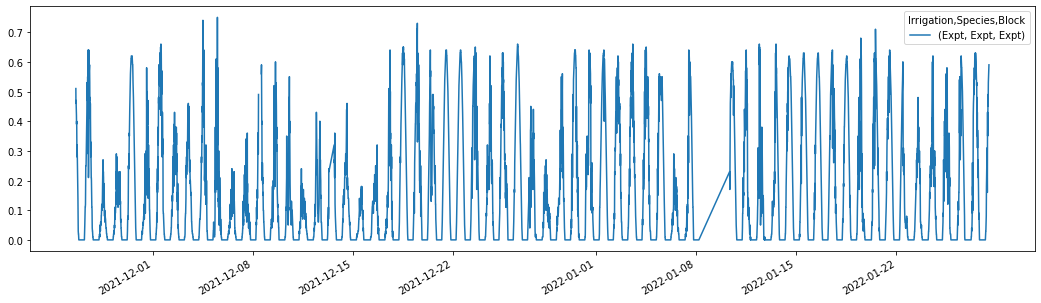

In [80]:
Data.IncomingRadnMJ.loc[Start:End].plot(figsize=(18,5))

### Values less that 0.002 MJ/h can be treated as dark

### Create a tuple of the time stamps that have radiation > 0.002 MJ/h

In [81]:
DaylightIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()

In [82]:
np.save('.\DataFrames\DaylightIndex.npy',DaylightIndex)

### Create temperature dataframes with daylight data

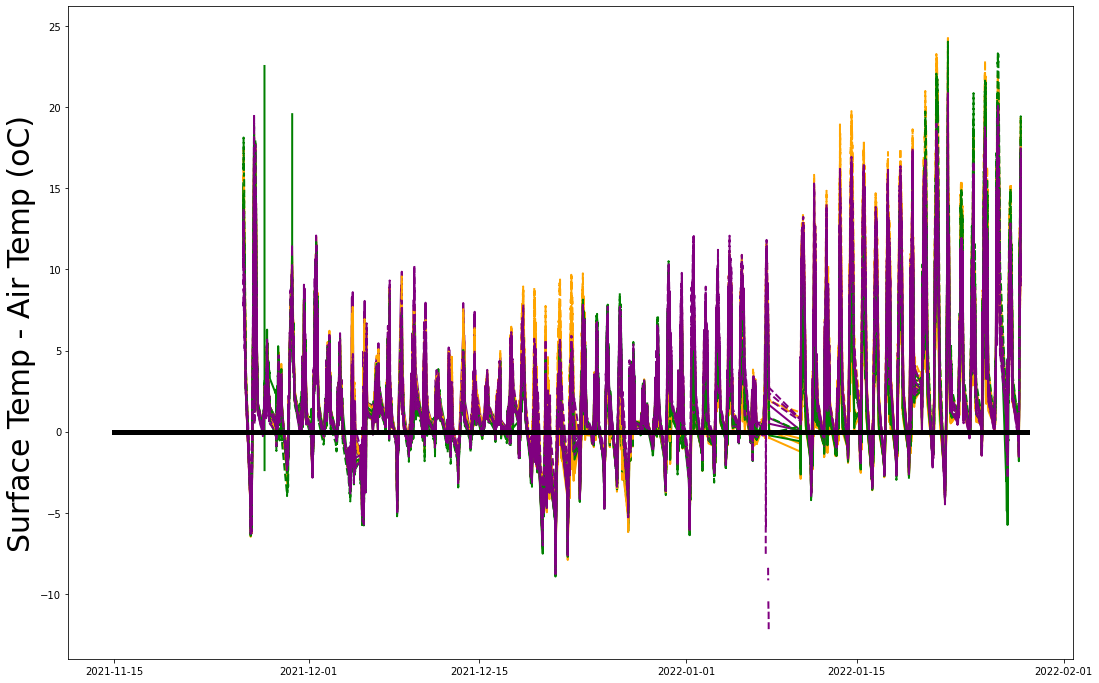

In [83]:
Figure = plt.figure(figsize=(18, 12))
ax = Figure.add_subplot(1,1,1)
GH.AddIndexedPlot(Data.loc[DaylightIndex,'TsTa'].loc[Start:End],ax,GPs,2)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.plot(pd.to_datetime([Start,End]),[0,0], c='k', linewidth=5)

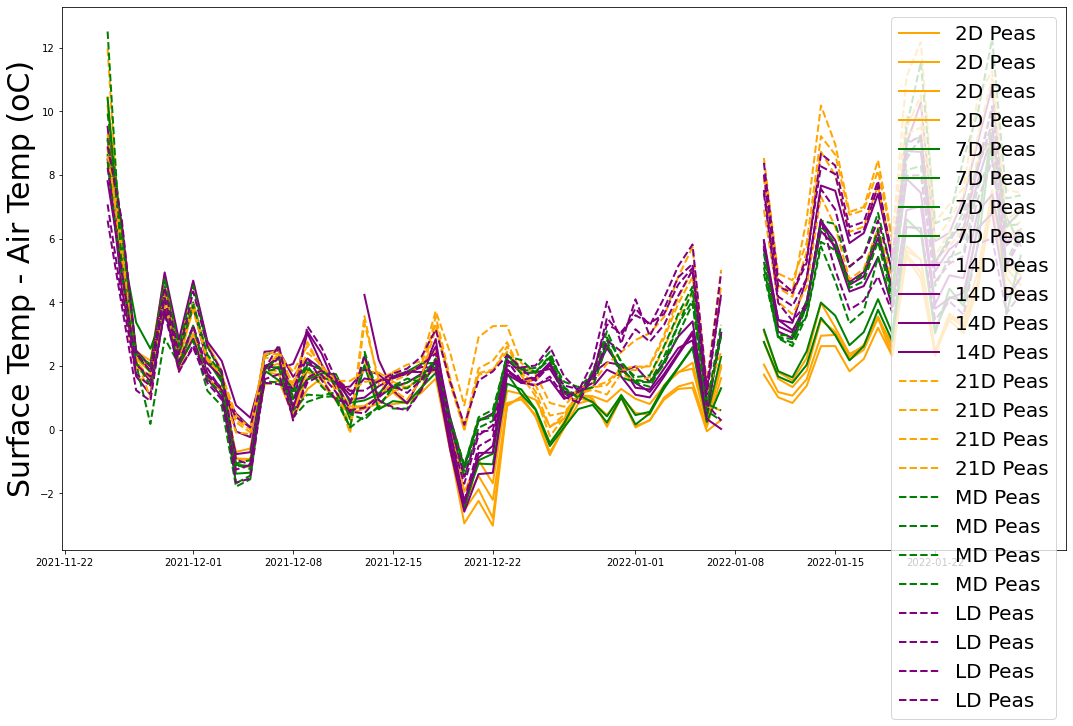

In [84]:
#Agregate data
DayTimeMeanTempDiff = Data.loc[DaylightIndex,'TsTa'].resample('D').mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(DayTimeMeanTempDiff.loc[Start:End,:],ax,GPs,2)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.legend(loc=1,fontsize=20)

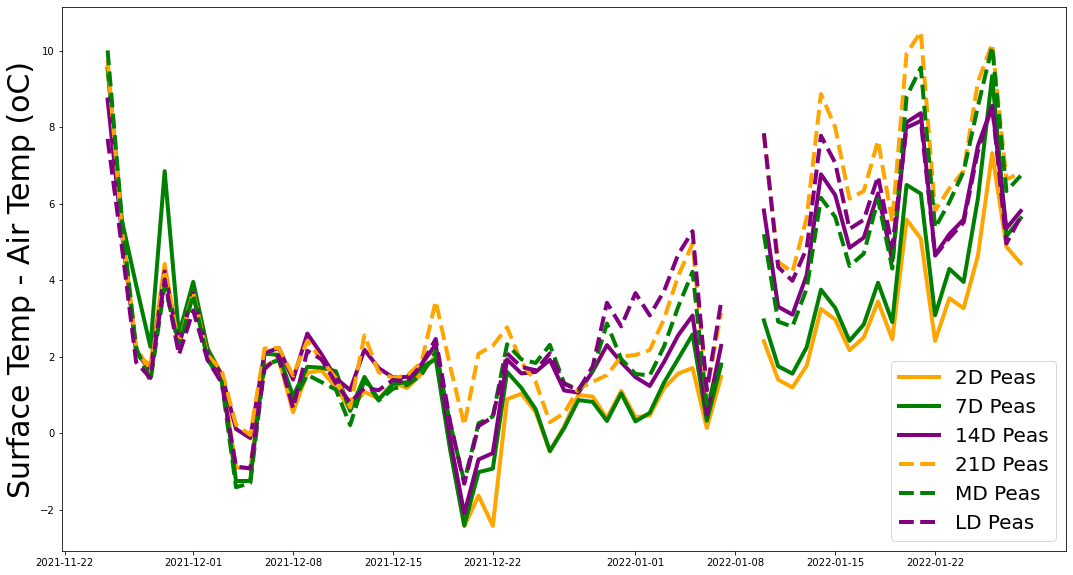

In [85]:
#Agregate data
DayTimeMeanTempDiff = DayTimeMeanTempDiff.groupby(level=['Irrigation','Species'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(DayTimeMeanTempDiff,ax,GPs,4)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.legend(fontsize=20)

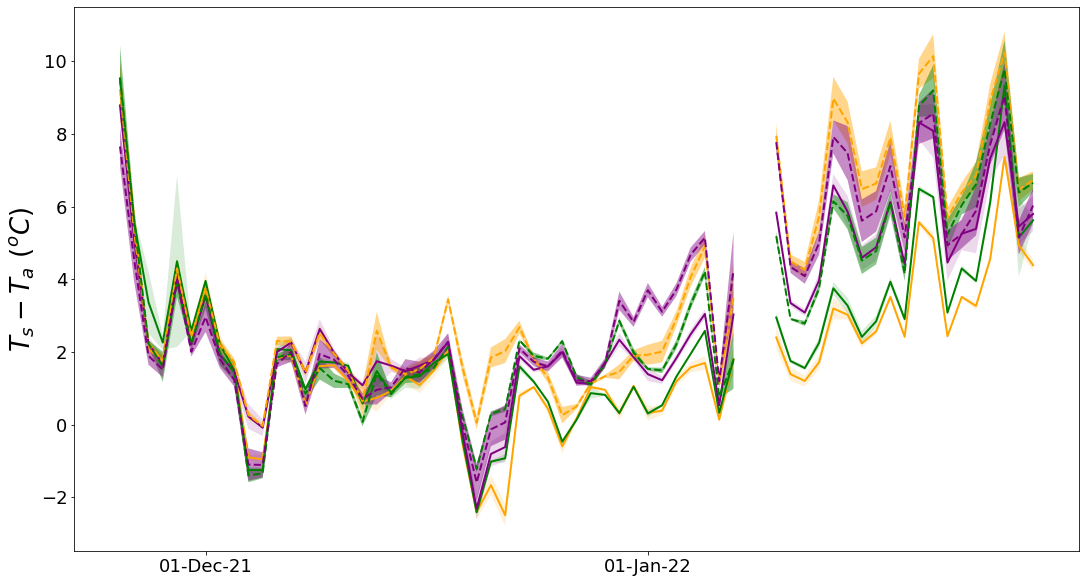

In [86]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(Data.loc[DaylightIndex,'TsTa'].resample('D').mean(),ax,GPs,2)
plt.ylabel('$T_s - T_a$ $(^oC)$', fontsize=26, weight='bold')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ax.tick_params(labelsize=18)    
#ax.plot(HighIrrigIndex,list(-4.8 for x in range(len(HighIrrigIndex))),'^',mec='k',mfc='w',markersize=16)
#ax.plot(DrylandIndex,list(-4.1 for x in range(len(DrylandIndex))),'^',c='k',markersize=16)

In [87]:
DayTimeMeanTempDiff.to_pickle('.\DataFrames\DayTimeMeanSurfaceTemp.pkl')

# Calculate additional variables

## Aerodynamic resistance (Ra)

In [88]:
Data.loc[:,('Ra','Expt', 'Expt','Expt')] = [et.Ra(Data.loc[x,'Windspeed'].values[0],1.2, 0.5) for x in Data.index]

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


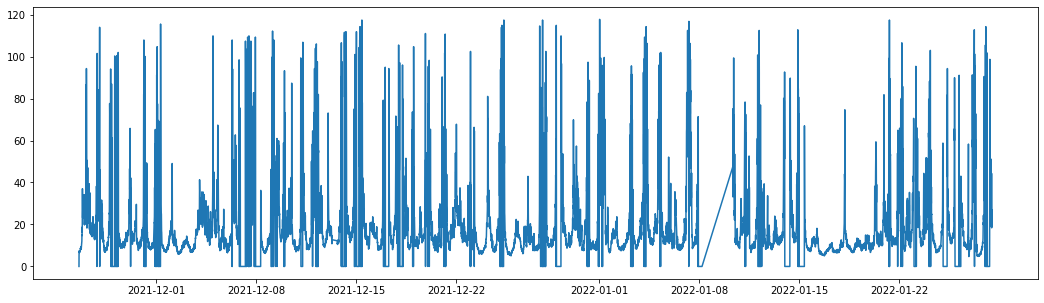

In [89]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.Ra)

## Saturated Vapor pressure (SatVP)

In [90]:
#Function returns SatVP in mbar.  Divide by 10 to convert to kPa
Data.loc[:,('SatVP','Expt', 'Expt','Expt')] = [et.saturated_vapor_pressure(Data.loc[x,'AirTemperature'].values[0])/10 for x in Data.index]

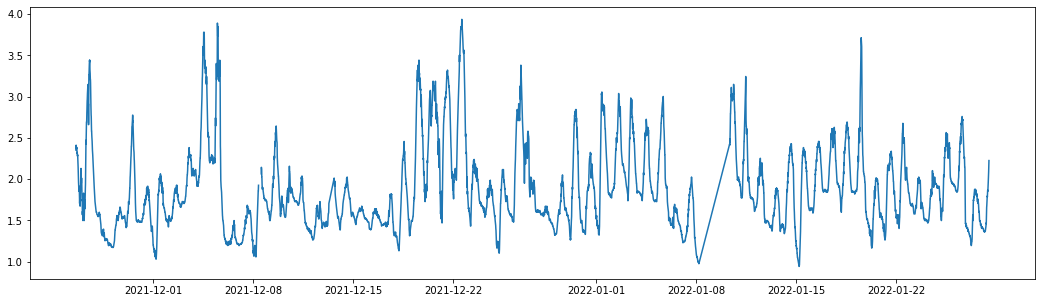

In [91]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.SatVP)

## Vapor pressure (VP)

In [92]:
Data.loc[:,('VP', 'Expt', 'Expt','Expt')] = [Data.loc[x,'SatVP'].values[0] * Data.loc[x,'RelativeHumidity'].values[0]/100 for x in Data.index]

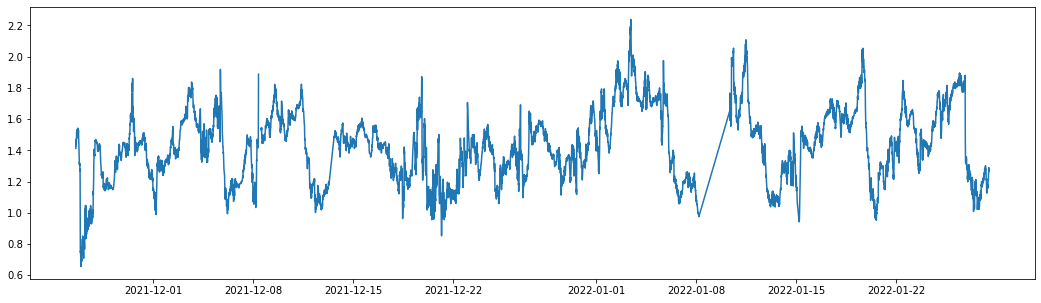

In [93]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.VP)

## Vapor pressure deficit (VPD)

In [94]:
Data.loc[:,('VPD', 'Expt', 'Expt','Expt')] = [Data.loc[x,'SatVP'].values[0] - Data.loc[x,'VP'].values[0] for x in Data.index]

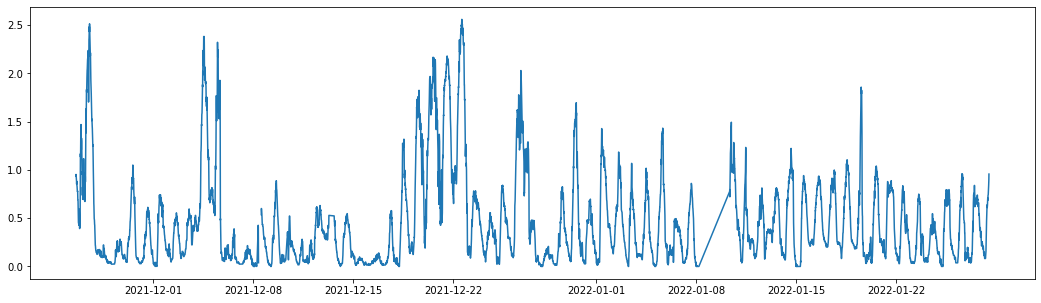

In [95]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.VPD)

Text(0.5, 0, 'Air Temperature oC')

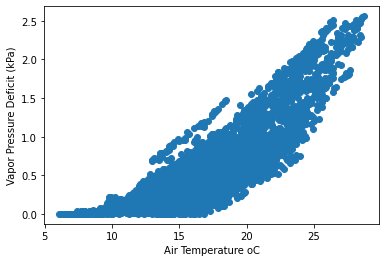

In [96]:
plt.plot (Data.AirTemperature, Data.VPD,'o')
plt.ylabel('Vapor Pressure Deficit (kPa)')
plt.xlabel('Air Temperature oC')

### VPD response to temperature is showing the sort of exponential relationship we would expect

## AirDensity (q)

In [97]:
Data.loc[:,('q','Expt','Expt','Expt')] = [et.AirDensity(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


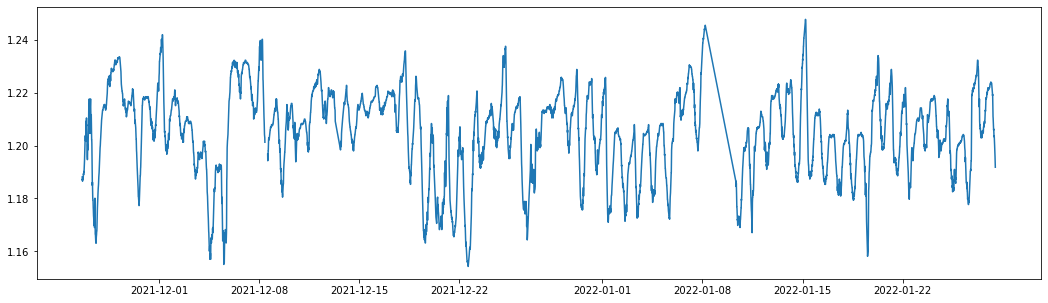

In [98]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.q)

## Phycometric constant (gamma)

In [99]:
Data.loc[:,('gamma','Expt','Expt','Expt')] = [et.gama(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

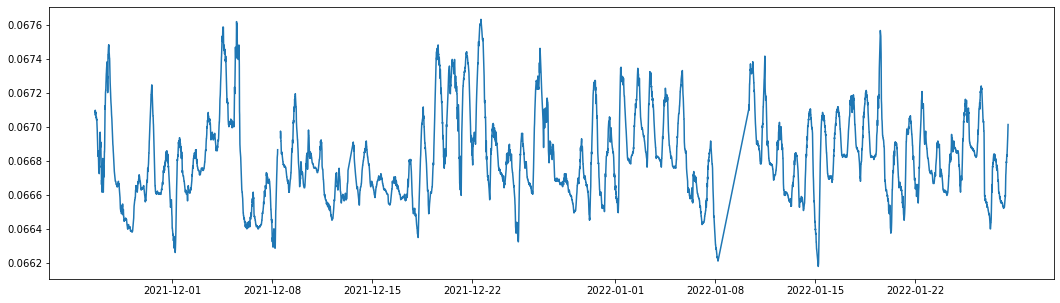

In [100]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.gamma)

## Slope of the satruarted vapour pressure curve (delta)

In [101]:
Data.loc[:,('delta','Expt','Expt','Expt')] = [et.saturated_vapor_pressure_slope(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

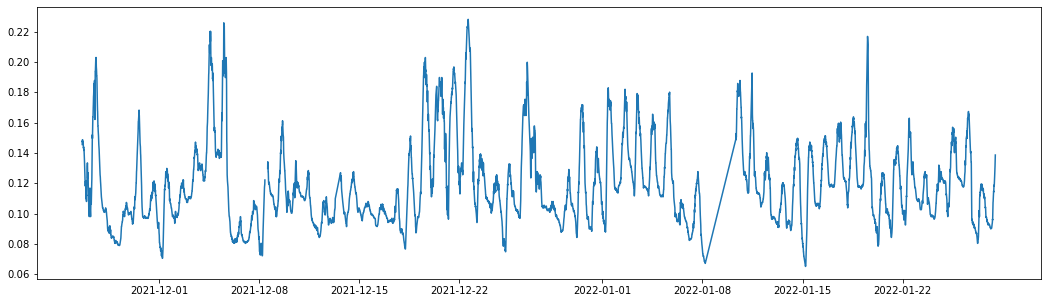

In [102]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.delta)

# latent heat of vaporisation (lamda)

In [103]:
Data.loc[:,('lamda','Expt','Expt','Expt')] = [et.lamda(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

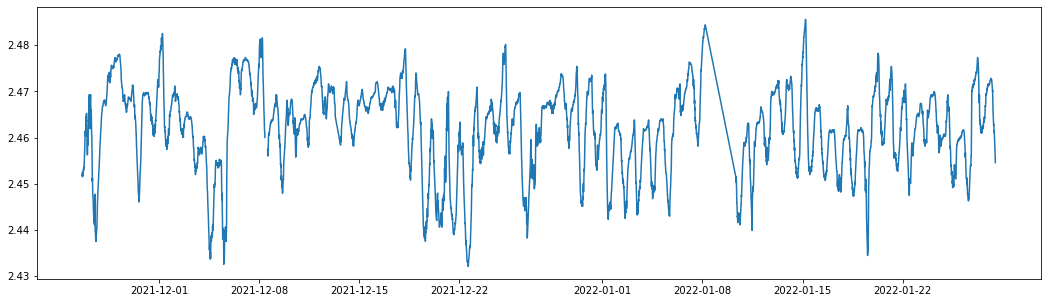

In [104]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.lamda)

## Duration (in hours)

In [105]:
def calcPeriod(End, Start):
    durat = End - Start
    secs = float(durat.seconds)
    _ret = secs/3600
    return _ret
    

In [106]:
Data.loc[:,('Duration','Expt','Expt','Expt')] = [calcPeriod(Data.index[x],Data.index[x-1]) for x in range(Data.index.size)]

(0.0, 0.4)

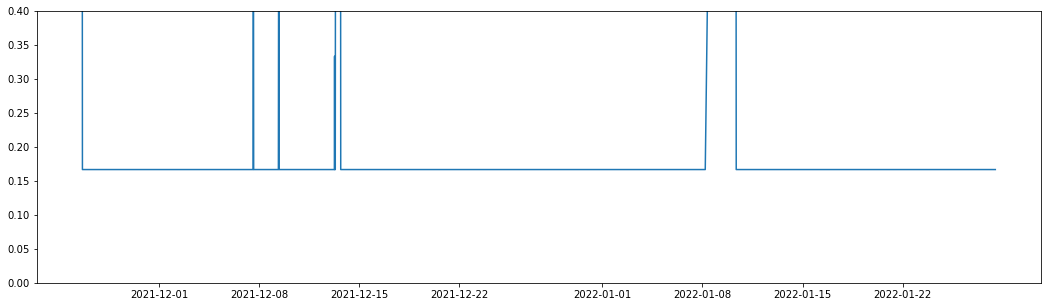

In [107]:
graph = plt.figure(figsize=(18,5))
plt.plot(Data.Duration)
plt.ylim(0,0.4)

## Time (in decimal hour scale, 0-24)

In [108]:
def calcTime(DateTimeOfInterest):
    When = DateTimeOfInterest.to_pydatetime()
    zerohour =  datetime.datetime(When.year, When.month, When.day, 0, 0)
    _hour = When - zerohour
    Hour = float(_hour.seconds)/3600
    _ret = 0
    if Hour >1:
        _ret = Hour-1
    else:
        _ret = 23 + Hour
    return _ret

In [109]:
Data.loc[:,('Time','Expt','Expt','Expt')] = [calcTime(Data.index[x]) for x in range(Data.index.size)]

<AxesSubplot:>

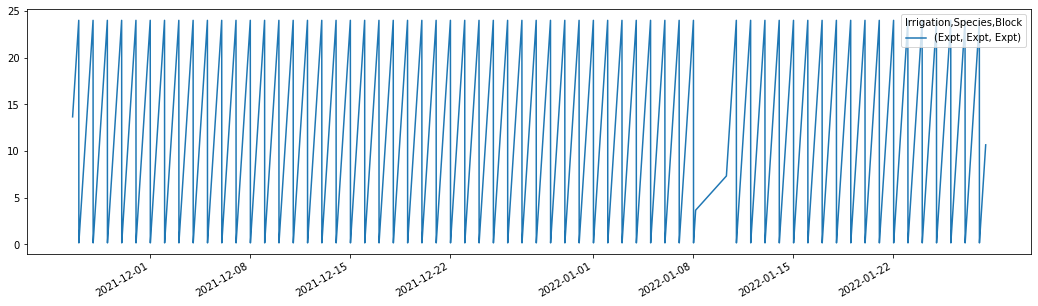

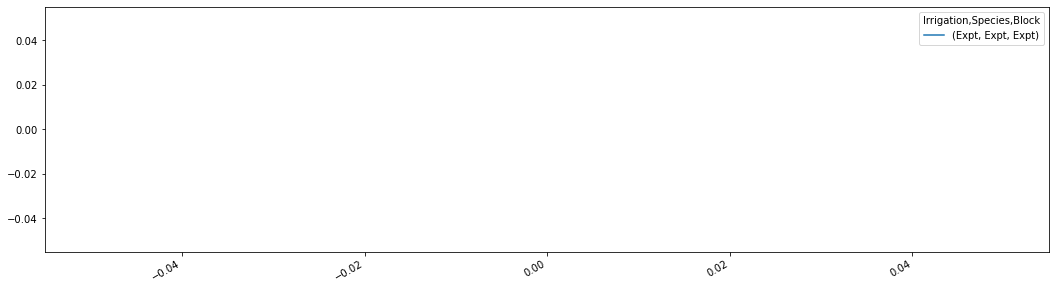

In [110]:
Data.Time.plot(figsize=(18,5))
Data.Time.loc['2018-12-1':'2018-12-5'].plot(figsize=(18,5))

In [111]:
Data.columns

MultiIndex([('AboveCanopyPAR', 'Expt', 'Expt', 'Expt'),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ('AboveCanopyPAR',    nan,    nan,    nan),
            ...
            (            'Ra', 'Expt', 'Expt', 'Expt'),
            (         'SatVP', 'Expt', 'Expt', 'Expt'),
            (            'VP', 'Expt', 'Expt', 'Expt'),
            (           'VPD', 'Expt', 'Expt', 'Expt'),
            (             'q', 'Expt', 'Expt', 'Expt'),
            (         'gamma', 'Expt', 'Expt', 'Expt'),
            (         'delta', 'Expt', 'Expt', 'Expt'),
            (         'lamda', '

## Extrateresteral radiation (Rex)

In [112]:
Data.loc[:,('Rex','Expt','Expt','Expt')] = [et.ExtraterestialRadiation(Lattitude,
                               x.dayofyear,
                               Data.loc[x,'Duration'].values[0],
                               Data.loc[x,'Time'].values[0],
                               LongitudeTZ,
                               LongitudeML) for x in Data.index]

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

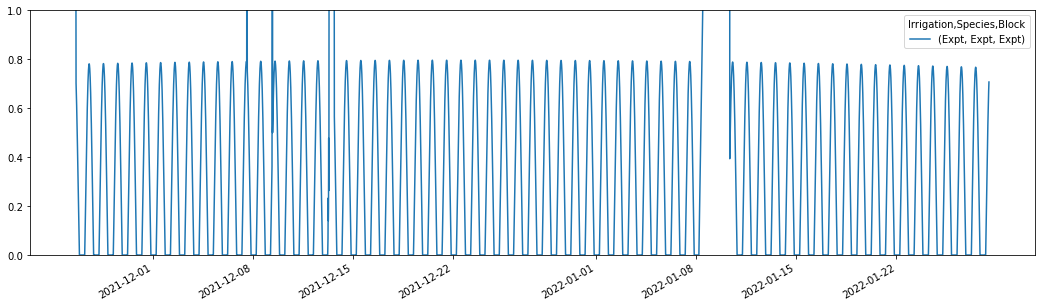

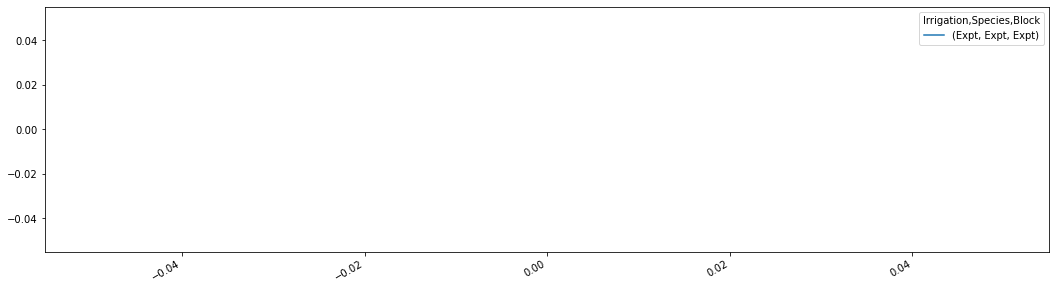

In [113]:
Data.Rex.plot(figsize = (18,5),ylim=(0,1))
Data.Rex.loc['2018-12-1':'2018-12-5'].plot(figsize = (18,5))

## Clear sky radiation (So)

In [114]:
Data.loc[:,('So','Expt','Expt','Expt')] = [et.ClearSkyRadiation(Lattitude,
                               x.dayofyear,
                               Data.loc[x,'Duration'].values[0],
                               Data.loc[x,'Time'].values[0],
                               LongitudeTZ,
                               LongitudeML) for x in Data.index]

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

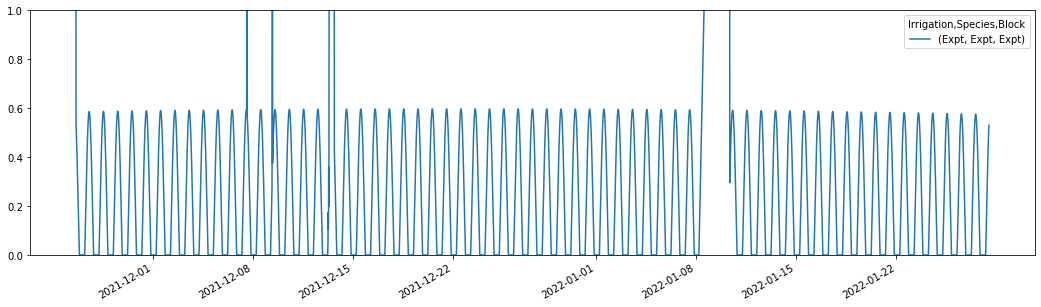

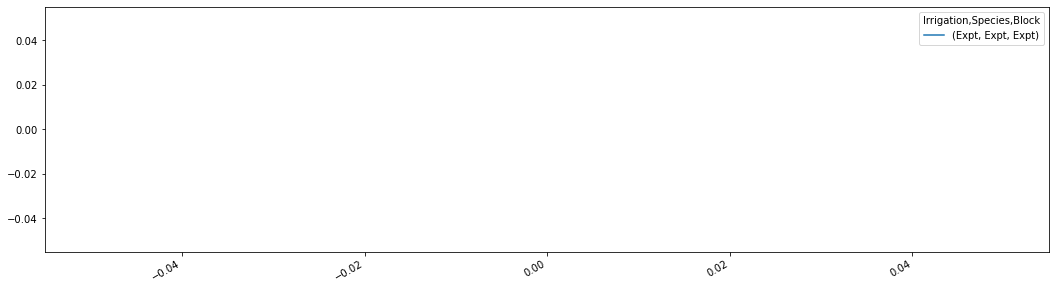

In [115]:
Data.So.plot(figsize = (18,5),ylim=(0,1))
Data.So.loc['2018-12-1':'2018-12-5'].plot(figsize = (18,5))

## Nett Radiation (Rn)

### Calculation Net radiation in MJ/m2

### Bring in plot specific albedo data

In [116]:
Data.loc[:,('RnMJ','Expt','Expt','Expt')] = [et.NetRadiation(Data.loc[x,'IncomingRadnMJ'].values[0],
                              Data.loc[x,'AirTemperature'].values[0],
                              Data.loc[x,'VP'].values[0],
                              Lattitude,
                              x.dayofyear,
                              Data.loc[x,'Duration'].values[0],
                              Data.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              Albedo) for x in Data.index]

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

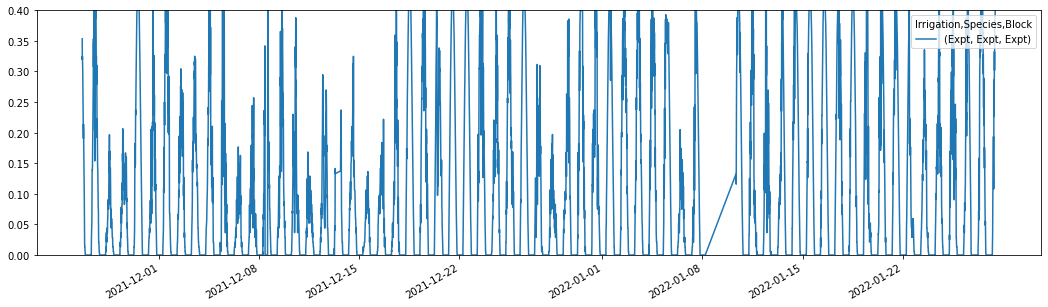

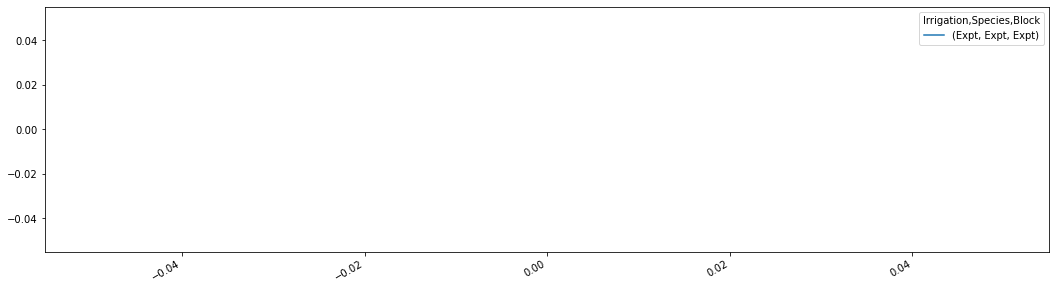

In [117]:
Data.RnMJ.plot(figsize = (18,5),ylim=(0,0.4))
Data.RnMJ.loc['2018-12-1':'2018-12-5'].plot(figsize = (18,5))

Text(0.1, 20, 'Slope = 0.66')

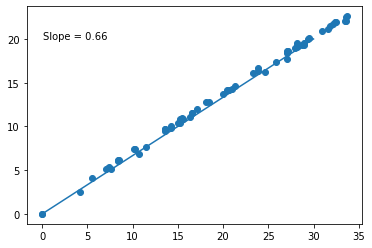

In [118]:
plt.scatter(Data.IncomingRadnMJ.resample('D').sum(),
Data.RnMJ.resample('D').sum())
plt.plot([0,30],[0,20],'-')
plt.text(0.1,20,'Slope = 0.66')

In [119]:
Broadfields = pd.read_pickle('C:\GitHubRepos\Weather\Broadfields\BroadFieldsDaily.pkl')

In [120]:
Broadfields.loc[datetime.datetime.strptime('2021-11-15','%Y-%m-%d'):datetime.datetime.strptime('2022-01-29','%Y-%m-%d'),'IncomingRadnMJ']

Date
2021-11-15    28.92
2021-11-16    31.00
2021-11-17    19.51
2021-11-18    22.99
2021-11-19    31.57
              ...  
2022-01-25    20.97
2022-01-26    23.88
2022-01-27    28.68
2022-01-28    29.25
2022-01-29    27.53
Freq: D, Name: IncomingRadnMJ, Length: 76, dtype: float64

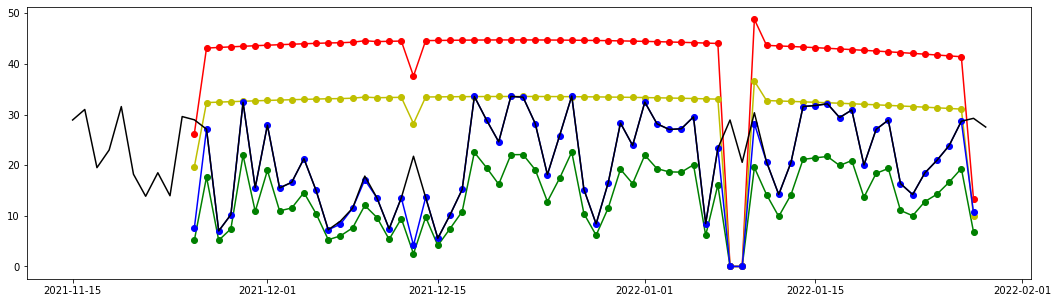

In [121]:
figure = plt.figure(figsize=(18,5))
plt.plot(Data.RnMJ.resample('D').sum(),'-o',color='g')
plt.plot(Data.Rex.resample('D').sum(),'-o',color='r')
plt.plot(Data.So.resample('D').sum(),'-o',color='y')
plt.plot(Data.IncomingRadnMJ.resample('D').sum(),'-o',color='b')
plt.plot(Broadfields.IncomingRadnMJ.loc['2021-11-15':'2022-01-29'], color = 'k')

### Net radiation data all looks good

### Convert to W/m2 by dividing by the period duration in seconds

In [122]:
def calcRnW(RnMJseries,DurationSeries):
    Return = []
    for x in RnMJseries.index:
        if DurationSeries.loc[x][0] == 0:
            Return.append(0)
        else:
            Return.append((RnMJseries.loc[x][0]*1000000)/(DurationSeries.loc[x][0]*3600)) #Multiply by a million to convert to jouls and by 3600 to convert from hours to seconds
    return Return    

In [123]:
Data[('RnW','Expt','Expt','Expt')] = calcRnW(Data.loc[:,'RnMJ'],Data.loc[:,'Duration'])

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2895: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3072: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


<AxesSubplot:>

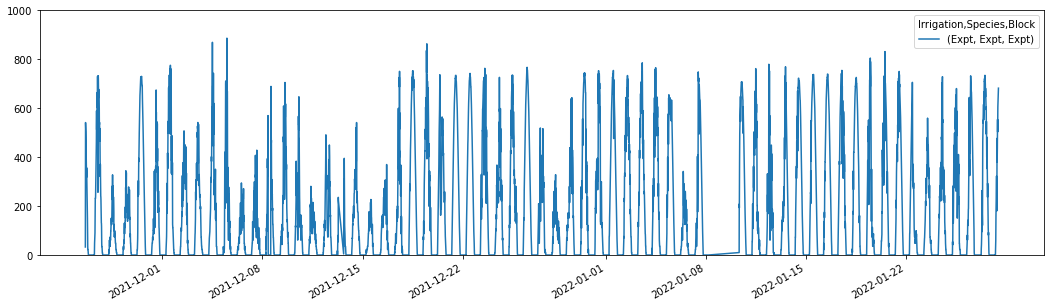

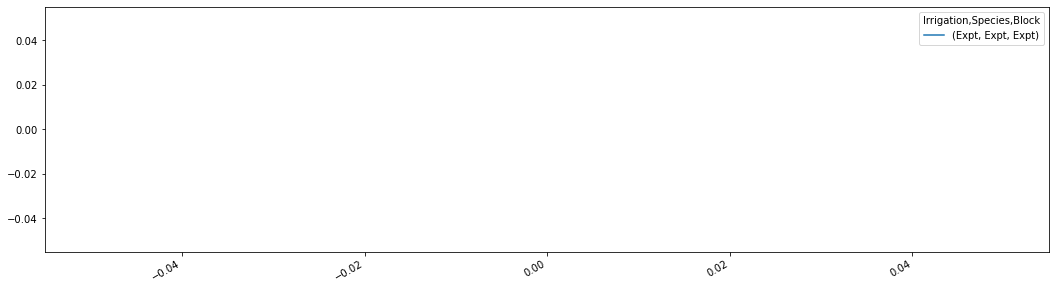

In [124]:
Data.RnW.plot(figsize = (18,5),ylim=(0,1000))
Data.RnW.loc['2018-12-1':'2018-12-5'].plot(figsize = (18,5))

### Instanious net radiation data looks sensible

In [125]:
Data.to_pickle('.\DataFrames\TempAndMet.pkl')

In [126]:
Data.loc[DaylightIndex,'IR_SurfaceTemp'].resample('D').mean().to_pickle('.\DataFrames\DailyTs.pkl')
Data.loc[DaylightIndex,'AirTemperature'].resample('D').mean().to_pickle('.\DataFrames\DailyTa.pkl')
Data.loc[DaylightIndex,'VPD'].resample('D').mean().to_pickle('.\DataFrames\DailyEd.pkl')
Data.loc[DaylightIndex,'IncomingRadnMJ'].resample('D').sum().to_pickle('.\DataFrames\DailyRs.pkl')
Data.loc[DaylightIndex,'VP'].resample('D').mean().to_pickle('.\DataFrames\DailyEa.pkl')
Data.loc[DaylightIndex,'Windspeed'].resample('D').mean().to_pickle('.\DataFrames\Dailyu.pkl')